## Problem Statement:

Create a HAR using video from the given classes. Essentially, take the sequences of keypoints and train a model for sequence classification. 

## Data Preprocessing

We can extract the keypoints of each frame in the every video using a keypoint detector and saving the inferences as a sequence. Since, each video can have a variable length, the sequence length could be different for each video. The sequence length also depepnds upon the number of frames in which a subject it present over which the keypoint detection can be preformed. 

I conducted my experiments with 2 keypoint generators.

- Mediapipe  : Provides 33 keypoints (as per the assignment)
- Torchvision: Provides 17 keypoints 

From the looks of it, it seems like since mediapipe is generating more number of keypoints, it would be a better choice. But I ran into an issue where mediapipe keypoint generation kept on failing on the validation videos. However, the torchvision library that generates only 17 points, had a similar performance on train and test set. 



#### Asumption
My solution primarily hinges on two assumptions:

- Since 1 second of video typically contains 24 to 30 frames, there is not a lot of variance from frame to frame in the keypoint locations. Hence, a fair assumtion that I made to reduce the inferencing cost and time is that, instead of all the frames, every 5th frame has been used to get the key point location.

- Sequences with fairly low length can be ignored as they won't have enough context. The hyperparameter: `min_det_threshold` deals with the number the said length.



In [3]:
import json
import numpy as np 
import tensorflow as tf
import os
import cv2

seed = 4
np.random.seed(seed)
tf.random.set_seed(
    seed
)
from numpy import mean
from numpy import std

from tqdm import tqdm
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split


# Data Overview


The data has to be loaded from the json files. The json files were created by looping over all the frames in a video and generating the keypoint location from the detector. 

### Data Loading

- Read the Jsons
- Keep the data of the json which have sequence length > `min_det_threshold`

In [4]:
min_det_threshold = 20 # To remove noise(videos with little to no frames with keypoints), we will set some minimum detection threshold

In [5]:
data_dir = "./train_json/"
train_dir = "./trimmed/train/"

cat = []
data = []



for k,cls in enumerate(tqdm(os.listdir(train_dir))):#loop over all the video files in the folder 
    
    for vid in os.listdir(os.path.join(train_dir, cls)): 
        
        video_path = os.path.join(os.path.join(train_dir, cls),vid)
#         cap = cv2.VideoCapture(video_path)

        
        f = open(os.path.join(data_dir, vid+"_data_val.json")) # read the json data of the given file
        frame_data = json.load(f)
        
        frame_ls = []
        
        for frame in range(len(frame_data["filename"]["keypoints"])):
            keypts_ls = []

            for det in ((frame_data["filename"]["keypoints"][frame])):
#                 print((det))
#                 dist = (det[0]**2+det[1]**2)**0.5
#                 keypts_ls.append(dist)
                keypts_ls.append(det[0])
                keypts_ls.append(det[1])
            
            frame_ls.append(keypts_ls)
        
#         print(f"Total Frames shape {vid} : {np.array(frame_ls).shape}")

            

        if len(frame_ls) > min_det_threshold:# reject frame_ls with len < min_det_threshold
            data.append(frame_ls)
            cat.append(k)



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]


### Handling the class imbalance

The initial eda suggests that there is a class imbalance, specially with the category called squats. 

Potential Solutions:

- Over Sampling: We can use syntetic sampling techniquies that rely on interpolation/duplication to increase the number of the minority class.
- We can also use sample_weight parameter of model.fit( ) function. Sample_weigths tells the NN to treat the data with categorical weightage. Categorical weightage is inversely proportional to the number of samples per class.


In my experiments, over sampling yielded a better recall on the test set but there wasn't any significant improvement in the val set accuracy while sample_weight did improve the precision and recall for the minority category.

Also, during one of my experiments, I removed the last category (Squats) and trained the model on the remaining 4 classes. Doing so resulted in an accuracy of over 80%. It means that increasing the data for the minority class will result in significant improvement.

In [6]:
from matplotlib import pyplot as plt
from collections import Counter

class_counts_train = Counter(cat)
print(class_counts_train)


Counter({1: 87, 2: 86, 0: 75, 3: 74, 4: 55})
[0.01333333 0.01149425 0.01162791 0.01351351 0.01818182]


#### Oversampling

We can use imbalance learner lib to over sample the data. Since I just wanted to increase the number of the least frequent class, it was easier to duplicate few of the samples.


In [7]:
# from imblearn.over_sampling import SMOTE
import random 

duplicate_data = []
duplicate_cat  = []

for ex in range(353, len(data)):
    prob = np.random.randint(2, size=1)[0]
    
    if prob:
        duplicate_cat.append(cat[ex])
        duplicate_data.append(data[ex])
        
data.extend(duplicate_data)
cat.extend(duplicate_cat)

class_counts_train = Counter(cat)
print(class_counts_train)

class_weights = np.array([1/i for i in class_counts_train.values()])
# class_weights[3], class_weights[4] = class_weights[3]*1.15, class_weights[4]*1.25 
print(f'New sample_weights per class: {class_weights}')

Counter({1: 87, 2: 86, 0: 75, 3: 74, 4: 65})
New sample_weights per class: [0.01333333 0.01149425 0.01162791 0.01351351 0.01538462]


In [8]:
val_data_dir = "./val_json/"
val_dir = "./trimmed/val/"

val_cat = []
val_data = []



for k,cls in enumerate(tqdm(os.listdir(val_dir))):
    
    for vid in os.listdir(os.path.join(val_dir, cls)):

        f = open(os.path.join(val_data_dir, vid+"_data_val.json"))
        frame_data = json.load(f)
        
        frame_ls = []
        
        for frame in range(len(frame_data["filename"]["keypoints"])):
            keypts_ls = []

            for det in ((frame_data["filename"]["keypoints"][frame])):
#                 print((det))
#                 dist = (det[0]**2+det[1]**2)**0.5
                
                keypts_ls.append(det[0])
                keypts_ls.append(det[1])
            
            frame_ls.append(keypts_ls)
   

        if len(frame_ls) > min_det_threshold:
            val_data.append(frame_ls)
            val_cat.append(k)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.63it/s]


In [9]:
class_counts_val = Counter(val_cat)
print(class_counts_val)

Counter({0: 27, 1: 26, 2: 24, 3: 24, 4: 18})


The validation dataset is pretty balanced already.

##### Data format
X: [N, F,C]


Where:
- N : Number of videos
- F : Frames
- C : Cordinates (x,y)

###### Y: [cat(int)]

## One Hot Encoding
Vectorize the target 

Y[int] > Y[Vector]

In [10]:
category = np.array(cat).reshape(-1,1)
enc = OneHotEncoder()
enc.fit(category)
onehotlabels = enc.transform(category).toarray()  

y_val =  enc.transform(np.array(val_cat).reshape(-1,1)).toarray() 

print(f"y_train shape:  {onehotlabels.shape}\t y_val shape: {y_val.shape}")

y_train shape:  (387, 5)	 y_val shape: (119, 5)


## Sequence Modeling 

I experimented with various LSTM models for sequence classification. The best performance was observed in the ConvLSTM models. ConvLSTM. The Convolutional LSTM architectures bring together time series processing and computer vision by introducing a convolutional recurrent cell in a LSTM layer. 

Input shape: 5D tensor with shape - (samples, timesteps, filters, new_rows, new_cols)


### Model Hyperparameters

- max_seq_length: The maximum length of sequence while padding and trimming
- n_steps : timestep paramter
- n_length: length of sequences
- n_steps * n_length = max_seq_length 
- holdout_ratio : Ratio of data to be ignored
- num_conv_filter: Number of filters in convlstm layer
- filter_size: The size of the filters

In [11]:
max_seq_length= 45
n_steps, n_length = 5,9
test_size = .3
verbose, epochs, batch_size = 0, 75, 120
num_conv_filter = 64
filter_size = (1,9)

### Data loading pipeline 

- Pad the sequences with 0s 
- Use train_test_split for train and test datasets
- Load validation dataset after the padding  

In [12]:
from sklearn.model_selection import train_test_split

sc = StandardScaler()


def load_dataset():

    X = sequence.pad_sequences(data, maxlen=max_seq_length)
    X_scaled = sc.fit_transform(X.reshape(-1,X.shape[1]*X.shape[2]))
    X_scaled = X_scaled.reshape(X.shape)
    
    X_val = sequence.pad_sequences(val_data, maxlen=max_seq_length)
    X_val_scaled = sc.fit_transform(X_val.reshape(-1,X_val.shape[1]*X_val.shape[2]))
    X_val_scaled = X_val_scaled.reshape(X_val.shape)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, onehotlabels ,test_size=test_size)

    return X_train, y_train, X_test, y_test, X_val_scaled, y_val

In [13]:
X_train, y_train, X_test, y_test, X_val_scaled, y_val = load_dataset()

print(f"x_train shape \t:\t{X_train.shape}\t y_train shape\t:\t{y_train.shape}")

print(f"x_test shape \t:\t{X_test.shape}\t y_test shape\t:\t{y_test.shape}")

print(f"x_val shape  \t:\t{X_val_scaled.shape}\t y_val shape\t:\t{y_val.shape}")

x_train shape 	:	(270, 45, 34)	 y_train shape	:	(270, 5)
x_test shape 	:	(117, 45, 34)	 y_test shape	:	(117, 5)
x_val shape  	:	(119, 45, 34)	 y_val shape	:	(119, 5)


#### Model Helper

In [14]:
#sample_weigth generator using class_weight
def generate_sample_weights(training_data, class_weights): 
    sample_weights = [class_weights[np.where(one_hot_row==1)[0][0]] for one_hot_row in training_data]
    return np.asarray(sample_weights)

# plot model performance
def plot_history(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

### ConvLSTM Keras Model

In [15]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD



def get_model():
    
    
    #get dataset
    trainX, trainy, testX, testy, valx, valy = load_dataset()
    
    
    # define model
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    
    # reshape into subsequences (samples, time steps, rows, cols, channels)
    trainX = trainX.reshape((trainX.shape[0], n_steps, 1, n_length, n_features))
    testX = testX.reshape((testX.shape[0], n_steps, 1, n_length, n_features))
    valx = valx.reshape((valx.shape[0], n_steps, 1, n_length, n_features))

    
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=num_conv_filter, kernel_size=filter_size, activation='relu',
                         input_shape=(n_steps, 1, n_length, n_features),return_sequences = True))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.75))
    model.add(Dense(n_outputs, activation='softmax'))

#     opt = SGD(lr=0.01, momentum=0.9)
#   tf.keras.losses.CategoricalHinge()/
    model.compile(loss=tf.keras.losses.CategoricalHinge(), optimizer="adam", metrics=['accuracy'])
    # fit network
    hist = model.fit(trainX, trainy, epochs=epochs,validation_data=(testX, testy),
                     batch_size=batch_size, verbose=verbose,
                     sample_weight=generate_sample_weights(trainy, class_weights)
                    )
    
    plot_history(hist)
    _, accuracy = model.evaluate(valx, valy, batch_size=batch_size, verbose=0)
    y_pred = model.predict(valx)
        # evaluate model
    return  model, accuracy, y_pred, valy

#### Helper Functions for performance analysis

In [16]:
import sklearn
def performance(y_pred, y_test):
    
    truth_argmax = np.argmax(y_test, axis=1)
    pred_argmax = np.argmax(y_pred, axis=1)
    
    test_cm = sklearn.metrics.confusion_matrix(truth_argmax, pred_argmax)
    test_f1 = sklearn.metrics.f1_score(truth_argmax, pred_argmax, average='macro')
    test_precision = sklearn.metrics.precision_score(truth_argmax, pred_argmax, average='macro')
    test_recall = sklearn.metrics.recall_score(truth_argmax, pred_argmax, average='macro')
    test_kappa = sklearn.metrics.cohen_kappa_score(truth_argmax, pred_argmax)

    test_f1_micro = sklearn.metrics.f1_score(truth_argmax, pred_argmax, average='micro')
    test_f1_weighted = sklearn.metrics.f1_score(truth_argmax, pred_argmax, average='weighted')
    
    print("Confusion Matrix:\n ", test_cm)
    print("F1 Score:\t", test_f1)
    print("F1 micro:\t", test_f1_micro)
    print("F1 weight:\t", test_f1_weighted)
    print("Precision:\t", test_precision)
    print("Recall:   \t", test_recall)
        

### Cross Validation Pipeline

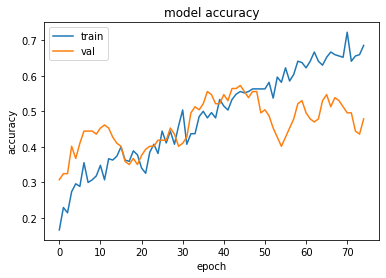

Best val-set accuracy so far: >#1: 52.941
Confusion Matrix:
  [[21  0  1  3  2]
 [11  1  1  2 11]
 [ 1  0 22  1  0]
 [ 1  0 10 10  3]
 [ 4  2  1  2  9]]
F1 Score:	 0.4711354405225799
F1 micro:	 0.5294117647058824
F1 weight:	 0.4714371220897239
Precision:	 0.4860183792815372
Recall:   	 0.5299145299145299


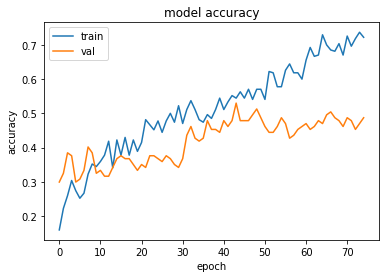

Best val-set accuracy so far: >#2: 57.143
Confusion Matrix:
  [[18  3  0  1  5]
 [ 5 13  1  2  5]
 [ 1  0 19  4  0]
 [ 0  0  6 14  4]
 [ 4  6  1  3  4]]
F1 Score:	 0.5493731431966726
F1 micro:	 0.5714285714285714
F1 weight:	 0.5683900298087149
Precision:	 0.5486050986050987
Recall:   	 0.5527777777777778


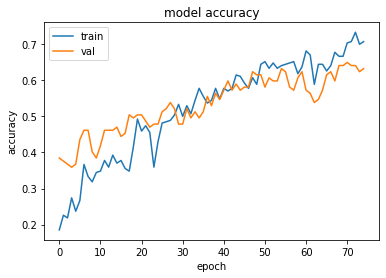

Best val-set accuracy so far: >#3: 60.504
Confusion Matrix:
  [[18  7  1  1  0]
 [ 4 17  1  3  1]
 [ 0  1 21  2  0]
 [ 0  1  9 13  1]
 [ 2  9  2  2  3]]
F1 Score:	 0.5652089352302312
F1 micro:	 0.6050420168067226
F1 weight:	 0.5839685377605679
Precision:	 0.6144817927170869
Recall:   	 0.5807692307692307


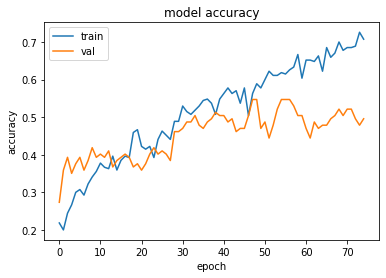

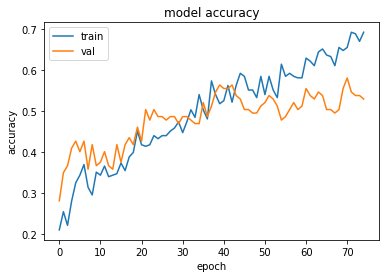

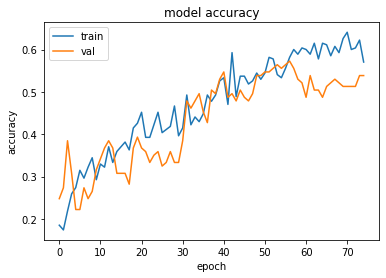

[52.941179275512695, 57.14285969734192, 60.5042040348053, 55.46218752861023, 57.983195781707764, 47.05882370471954]
Accuracy: 55.182% (+/-4.303)


In [17]:
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

def run_experiment(repeats=7):
#     X_train, y_train, X_test, y_test, X_val_scaled, y_val = load_dataset()
    
    best_model = None
    best_acc = 0
    
    scores = list()
    for r in range(repeats):
        
        model, accuracy, y_pred, testy = get_model()
        score = accuracy * 100.0
        
        if score > best_acc:
            best_acc = score
            best_model = model
            
            print(f"Best val-set accuracy so far: {'>#%d: %.3f' % (r+1, score)}")
            performance(y_pred, testy)

        scores.append(score)
 
    summarize_results(scores)
    return best_model

# run the experiment
model = run_experiment()

### Conclusion

Eventhough the data quantity was less, the following can be inferred:
- Though the model capacity wasn't high, the model starts overfitting because the dataset
- The testset accuracy highly correlates to the validation set meaning that the effect of class imbalance has been mitigated to some extent.
- With more data, the model perfomance will increase.
- With automated hyperparameter search there could be some improvement to the val accuracy.



### Further Experiments/Improvements

